# Downloading and displaying images of stellar clusters

In this notebook, we will download FFIs of several stellar clusters using TESScut and display them with matplotlib. The clusters we will be working with are:
- IC 4725
- M34
- Pleiades
- M7
- NGC 752
- IC 4665
- M24
- IC 2391
- Omega Cen
- 47 Tuc
- M4
- NGC 6752

In [174]:
%matplotlib inline
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
import numpy as np

PIXELS = 100
POSITIONS = {"IC 4725":(277.94486, -19.11496), "M34":(40.53083, 42.74615), "Pleiades":(56.86909, 24.10531), 
             "M7":(268.46325, -34.79283), "NGC 752":(29.421, 37.785), "IC 4665": (266.61324, 5.64874),
             "M24": (274.23385, -18.51456), "IC 2391": (130.133, -53.033), "Omega Cen": (201.69121, -47.47686),
             "47 Tuc": (6.022329, -72.081444), "M4": (245.89675, -26.52575), "NGC 6752": (287.71575, -59.98185)}

In [175]:
NAME = "NGC 752"
fits_file = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0}&dec={1}&y={2}&x={2}&units=px&sector=All".format(
    POSITIONS[NAME][0], POSITIONS[NAME][1], PIXELS)
print(fits_file)
#fits_file="https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=268.46325&dec=-34.79283&y=20&x=20&units=px&sector=All"
#print(fits_file)
fits.info(fits_file)

https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra=29.421&dec=37.785&y=100&x=100&units=px&sector=All
Filename: /home/jtdinsmo/.astropy/cache/download/py3/c71e36ebfd33845e51ddb46b3a003248
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  PIXELS        1 BinTableHDU    280   1107R x 12C   [D, E, J, 10000J, 10000E, 10000E, 10000E, 10000E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        80   (100, 100)   int32   


Open the file, load the image data, and close it.

In [176]:
with fits.open(fits_file, mode = "readonly") as hdulist:
    wcs_info = WCS(hdulist[1].header)
    cal_image = hdulist[1].data['FLUX']
    header = hdulist[1].header
    
#mid_time = 0.5 * (header['TSTOP'] + header['TSTART'])# Use the middle of the exposure
frameIndex = int(0.5 * cal_image.shape[0])

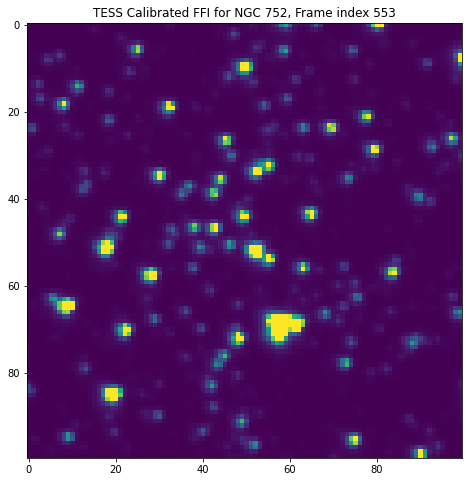

In [192]:
plt.figure(figsize = (8,8))

BRIGHTNESS_PERCENTILES = {"M7":[20, 100], "NGC 752":[0, 99]}
def get_brightness():
    if NAME in BRIGHTNESS_PERCENTILES:
        return BRIGHTNESS_PERCENTILES[NAME]
    return [4, 98]

#plt.subplot(111, projection = wcs_info)
plt.imshow(cal_image[frameIndex], vmin = np.percentile(cal_image[frameIndex],get_brightness()[0]),
           vmax = np.percentile(cal_image[frameIndex], get_brightness()[1]))
plt.title("TESS Calibrated FFI for " + NAME + ", Frame index %i" % frameIndex);